### Analysis

In [64]:
import pandas as pd
import numpy as np
import sklearn.datasets as skd
import scipy.stats as st
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

mydata= pd.read_csv('/resources/data/Salaries.csv')
rank = mydata['rank']
discipline = mydata['discipline']
service = mydata['yrs.service']
yrs = mydata['yrs.since.phd']
sex = mydata['sex']
salary = mydata['salary']

In [65]:
#What percentage of records are Assistant Professors with less that 5 years of experience?
ap = (rank == 'AsstProf').astype(int)   #Variable that is 1 if assistant professor and 0 otherwise
exp5 = (yrs < 5).astype(int)   #Variable that is 1 if less than 5 years of experience and 0 otherwise
apexp5 = ap*exp5   #Variable that is 1 if assistant professor with less than 5 years experience and 0 otherwise
percent = sum(apexp5)/len(apexp5) 
percent
'{:.1%}'.format(percent)

'9.1%'

MannwhitneyuResult(statistic=5182.5, pvalue=0.00821901039537954) 39 358


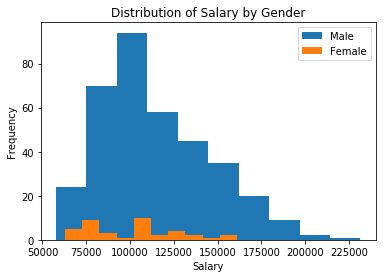

In [66]:
#Is there a statistially significant difference between male and female salaries?

#Segment salary into male and female sets
fsal = []
msal= []
for i in range(len(salary)):
    if sex[i] == 'Female':
        fsal.append(salary[i])
    elif sex[i] == 'Male':
        msal.append(salary[i])

#Compare distributions
plt.hist(msal)
plt.hist(fsal)
plt.title("Distribution of Salary by Gender")
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend(["Male","Female"],fancybox=True)
plt.savefig("figure1.png", transparent = True)

#From the plot, male salaries may be modeled by a lognormal distribution.
#Distribution of female salaries is less apparent, but this may be due to a smaller sample size.
#A Mann-Whitney U-Test is appropriate in this case, as precise distributions are unkown sample sizes are greater than 20.

#Run a Mann-Whitney U-Test
#Null: No difference between male and female salaries
#Alternative: Difference between male and female salaries
mwu = st.mannwhitneyu(fsal,msal, use_continuity = False, alternative = 'two-sided')
print(mwu, len(fsal),len(msal))


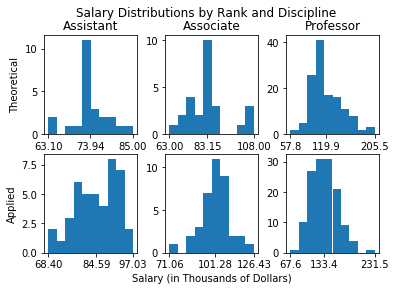

In [67]:
#What is the distribution of salary by rank and discipline?

#Define a function to remove specified values from a list
def removeval(ourlist, val):
        while val in ourlist:
            ourlist.remove(val)
        return ourlist

#Create binary variables for each rank and discipline (1 if value, 0 otherwise)
theo = (discipline == "A").astype(int)
app = (discipline == "B").astype(int)

asst = (rank == "AsstProf").astype(int)
assoc = (rank == "AssocProf").astype(int)
prof = (rank == "Prof").astype(int)

#Plot salaries for theoretical records of each rank
a = list(theo*asst*salary/1000)
removeval(a,0)
plt.subplot(231)
plt.hist(a)
plt.xticks([min(a),np.mean(a),max(a)])
plt.ylabel("Theoretical")
plt.title("Assistant")

b = list(theo*assoc*round(salary/1000))
removeval(b,0)
plt.subplot(232)
plt.hist(b)
plt.xticks([min(b),np.mean(b),max(b)])
plt.title("Associate")

c = list(theo*prof*salary/1000)
removeval(c,0)
plt.subplot(233)
plt.hist(c)
plt.xticks([min(c),np.mean(c),max(c)])
plt.title("Professor")

#Plot salaries for applied records of each rank
d = list(app*asst*salary/1000)
removeval(d,0)
plt.subplot(234)
plt.ylabel("Applied")
plt.hist(d)
plt.xticks([min(d),np.mean(d),max(d)])

e = list(app*assoc*salary/1000)
removeval(e,0)
plt.subplot(235)
plt.hist(e)
plt.xticks([min(e),np.mean(e),max(e)])
plt.xlabel("Salary (in Thousands of Dollars)")

f = list(app*prof*salary/1000)
removeval(f,0)
plt.subplot(236)
plt.hist(f)
plt.xticks([min(f),np.mean(f),max(f)])

#Minor adjustments to subplot format
plt.subplots_adjust(wspace = .3) #Increase space between graphs in each row
plt.suptitle('Salary Distributions by Rank and Discipline')
plt.savefig("figure2.png", transparent = True)

0    216
1    181
Name: discipline, dtype: int64

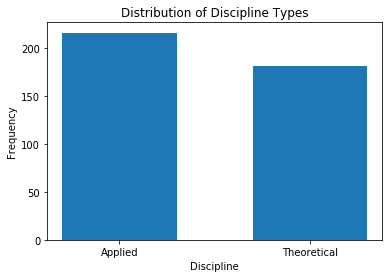

In [68]:
#How would you recode discipline as a 0/1 binary indicator
bindisc = (discipline == "A").astype(int) #Same command as previously

#Get a histogram for presentation
plt.hist(bindisc, bins = [-.3,.3,.7,1.3], align = 'mid')
plt.ylabel('Frequency')
plt.xlabel('Discipline')
plt.title("Distribution of Discipline Types")
plt.xticks([0,1], ["Applied","Theoretical"])
plt.savefig("figure3.png", transparent = True)

#Getting the sample sizes
bindisc.value_counts()

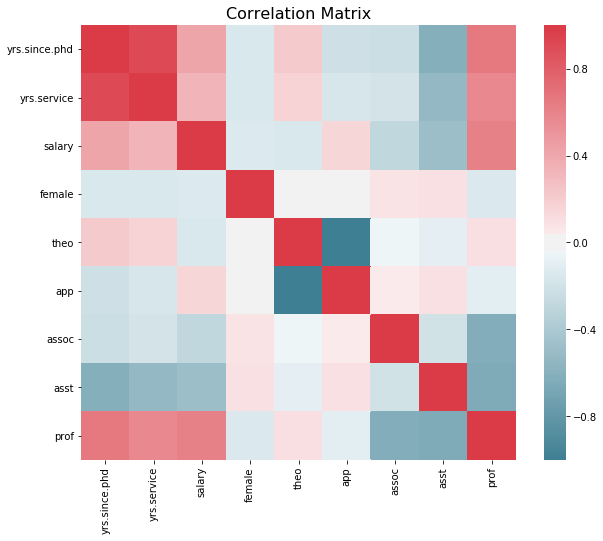

In [69]:
import seaborn as sns
#Add variables created in path tasks to the dataframe
female = (sex == "Female").astype(int)
mydata["female"] = female.values
mydata["theo"] = theo.values
mydata["app"] = app.values
mydata["assoc"] = assoc.values
mydata["asst"] = asst.values
mydata["prof"] = prof.values

#Create Correlation Heat Map to check for independence
f, ax = plt.subplots(figsize=(10, 8))
corr = mydata.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)
plt.title("Correlation Matrix", fontsize = 16)
plt.savefig("figure4.png", transparent = True)

### Model Building

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     63.41
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           2.40e-48
Time:                        13:28:28   Log-Likelihood:                -4541.4
No. Observations:                 397   AIC:                             9095.
Df Residuals:                     391   BIC:                             9119.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         8.66e+04   2960.308     29.252      

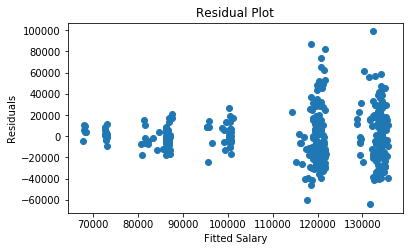

In [79]:
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

X = mydata[["female","yrs.service","theo", "prof", "assoc"]]
X = sm.add_constant(X)
#mydata["salary"] = np.log(salary)
Y = mydata["salary"]
model = sm.OLS(Y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the model statistics
print(model.summary())

#Model statistics again, but I am more familiar with this format
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[model],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Salary'],
                            info_dict=info_dict,
                            regressor_order=['const','female','theo', 'prof', 'assoc'])

results_table.add_title('Regression Model')

print(results_table) 

#Checking for homoskedasticity
#Goldfeld-Quandt test for homoskedasticity
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
print(name[0], test[0],name[1],test[1])

#Create Residual Plot
pred = model.fittedvalues.copy()
true = mydata['salary'].values.copy()
residual = true - pred

fig, ax = plt.subplots(figsize=(6,3.5))
_ = ax.scatter(pred,residual)
plt.title("Residual Plot")
plt.ylabel("Residuals")
plt.xlabel("Fitted Salary")
plt.savefig("figure5.png", transparent = True)

In [77]:
#Find median salary
medsal = np.median(salary)
print(medsal)

#Binary salary variable
overmedsal = (salary > medsal).astype(int)

#Add to data frame
mydata["overmedsal"] = overmedsal.values

107300.0


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
X = mydata[["female","theo","prof","assoc"]]
X = sm.add_constant(X)
Y = mydata["overmedsal"]
model = LogisticRegression()
model.fit(X, Y)

predicted_classes = model.predict(X)
accuracy = accuracy_score(Y,predicted_classes)
parameters = model.coef_
parameters, accuracy

/home/jupyterlab/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([[-1.11425895,  0.0691296 , -1.01003536,  3.64201263,  0.37640146]]),
 0.7934508816120907)